## Yolov5 

Use the verions `886f1c03d839575afecb059accf74296fad395b6` 

Therefore, you need to checkout to this commit ID

## Folder Structure


```bash 
../
├── sample_data
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
├── valid
│   ├── images
│   └── labels
└── yolov5
    ├── data
    │   ├── images
    │   └── scripts
    ├── models
    │   └── hub
    ├── utils
    │   ├── aws
    │   ├── google_app_engine
    │   └── wandb_logging
    └── weights

```

!git checkout 886f1c03d839575afecb059accf74296fad395b6

In [1]:
%set_env TRAIN_NAME="LPD_Lao_ChienKhuong_22-03-2023"

env: TRAIN_NAME="LPD_Lao_ChienKhuong_22-03-2023"


In [2]:
!nvidia-smi

Thu Mar 23 17:19:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1660    Off  | 00000000:01:00.0  On |                  N/A |
| 46%   37C    P8     7W / 130W |    926MiB /  5922MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/home/hunglv/Downloads/YOLO_DOCKER/yolov8


In [4]:
%cd $HOME

/usr/src/app


In [5]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

names:
- lao
- vn_1_line
- vn_2_line
nc: 3
roboflow:
  license: Private
  project: license-plate-fti9n
  url: https://app.roboflow.com/hungle/license-plate-fti9n/1
  version: 1
  workspace: hungle
test: LPD_LAO_ChienKhuong_21-03-2023_v1.0/test/images
train: LPD_LAO_ChienKhuong_21-03-2023_v1.0/train/images
val: LPD_LAO_ChienKhuong_21-03-2023_v1.0/val/images


In [6]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [7]:
num_classes

'3'

In [8]:
%cat {HOME}/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [9]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate {HOME}/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [11]:
%cat {HOME}/yolov5/models/custom_yolov5s.yaml


# parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

## Weights & Biases Logging 🌟 NEW

[Weights & Biases](https://www.wandb.com/) (W&B) is now integrated with YOLOv5 for real-time visualization and cloud logging of training runs. This allows for better run comparison and introspection, as well improved visibility and collaboration for teams. To enable W&B `pip install wandb`, and then train normally (you will be guided through setup on first use). 

During training you will see live updates at [https://wandb.ai/home](https://wandb.ai/home), and you can create and share detailed [Reports](https://wandb.ai/glenn-jocher/yolov5_tutorial/reports/YOLOv5-COCO128-Tutorial-Results--VmlldzozMDI5OTY) of your results. For more information see the [YOLOv5 Weights & Biases Tutorial](https://github.com/ultralytics/yolov5/issues/1289). 

<img src="https://user-images.githubusercontent.com/26833433/98184457-bd3da580-1f0a-11eb-8461-95d908a71893.jpg" width="800">

In [12]:
# Weights & Biases  (optional)
%pip install -q wandb
import wandb
wandb.login()

Note: you may need to restart the kernel to use updated packages.


wandb: Currently logged in as: hunglv213. Use `wandb login --relogin` to force relogin


True

In [12]:
%cd {HOME}/yolov5/

/usr/src/app/yolov5


In [17]:
!pip install -r requirements.txt

In [13]:
%set_env TRAIN_NAME=CN_VN_Lao_yolov5
%set_env EPOCH=5
%set_env MODEL_INPUT_SIZE=640

env: TRAIN_NAME=CN_VN_Lao_yolov5
env: EPOCH=5
env: MODEL_INPUT_SIZE=640


In [ ]:
!pip install comet_ml

In [18]:
!python train.py --img $MODEL_INPUT_SIZE --batch 16 --epochs $EPOCH --data '../data.yaml' --cfg models/custom_yolov5s.yaml --weights '' --name $TRAIN_NAME  --cache --log-artifacts --device 0

github: skipping check (Docker image)
YOLOv5 v4.0-126-g886f1c0 torch 1.13.1 CUDA:0 (GeForce GTX 1660, 5922.125MB)

Namespace(weights='', cfg='models/custom_yolov5s.yaml', data='../data.yaml', hyp='data/hyp.scratch.yaml', epochs=5, batch_size=16, img_size=[640, 640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=True, image_weights=False, device='0', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, log_imgs=16, log_artifacts=True, workers=8, project='runs/train', entity=None, name='CN_VN_Lao_yolov5', exist_ok=False, quad=False, linear_lr=False, world_size=1, global_rank=-1, save_dir='runs/train/CN_VN_Lao_yolov5', total_batch_size=16)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epoc

In [ ]:
# train yolov5s on custom data for 100 epochs
# !python train.py --img 640 --batch 8 --epochs 100 --data './data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name $TRAIN_NAME  --cache --artifact_alias=latest
# !python train.py --img 640 --batch 16 --epochs 100 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name $TRAIN_NAME  --cache --log-artifacts

train: weights=, cfg=./models/custom_yolov5s.yaml, data=./data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name="LPD_Lao_ChienKhuong_22-03-2023", exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.10.8 torch-1.13.1 CUDA:0 (GeForce GTX 1660, 5922MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [20]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard 
%tensorboard --logdir runsca

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
%cd {HOME}/yolov5

/home/hunglv/Downloads/YOLO_DOCKER/yolov8/yolov5


In [28]:
from IPython.display import display, Image

In [29]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='runs/train/yolov5s_results/results.png', width=1000)  # view results.png

FileNotFoundError: [Errno 2] No such file or directory: 'runs/train/yolov5s_results/results.png'

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

In [30]:
# first, display our ground truth data
%cd {HOME}/yolov5
print("GROUND TRUTH TRAINING DATA:")
Image(filename='runs/train/yolov5s_results/test_batch0_labels.jpg', width=900)

/workspace/yolov8/yolov5
GROUND TRUTH TRAINING DATA:


FileNotFoundError: [Errno 2] No such file or directory: 'runs/train/yolov5s_results/test_batch0_labels.jpg'

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='runs/train/yolov5s_results/train_batch0.jpg', width=900)

# Run Inference  With Trained Weights

Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [31]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [7]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd {HOME}/yolov5/
!python detect.py --weights runs/train/CN_VN_Lao_yolov55/weights/best.pt --img 640 --conf 0.4 --source LPD_LAO_ChienKhuong_21-03-2023_v1.0/test/images
#!python detect.py --weights runs/train/CN_VN_Lao_yolov55/weights/best.pt --img 640 --conf 0.4 --source LPD_LAO_ChienKhuong_21-03-2023_v1.0/test/images

/home/hunglv/Downloads/YOLO_DOCKER/yolov8/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='LPD_LAO_ChienKhuong_21-03-2023_v1.0/test/images', update=False, view_img=False, weights=['runs/train/CN_VN_Lao_yolov55/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.9.0+cu102 CUDA:0 (GeForce GTX 1660, 5922.125MB)

Fusing layers... 
/home/hunglv/anaconda3/envs/yolov5/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 232 layers, 7251912 parameters, 0 gradients, 16.8 GFLOPS
image

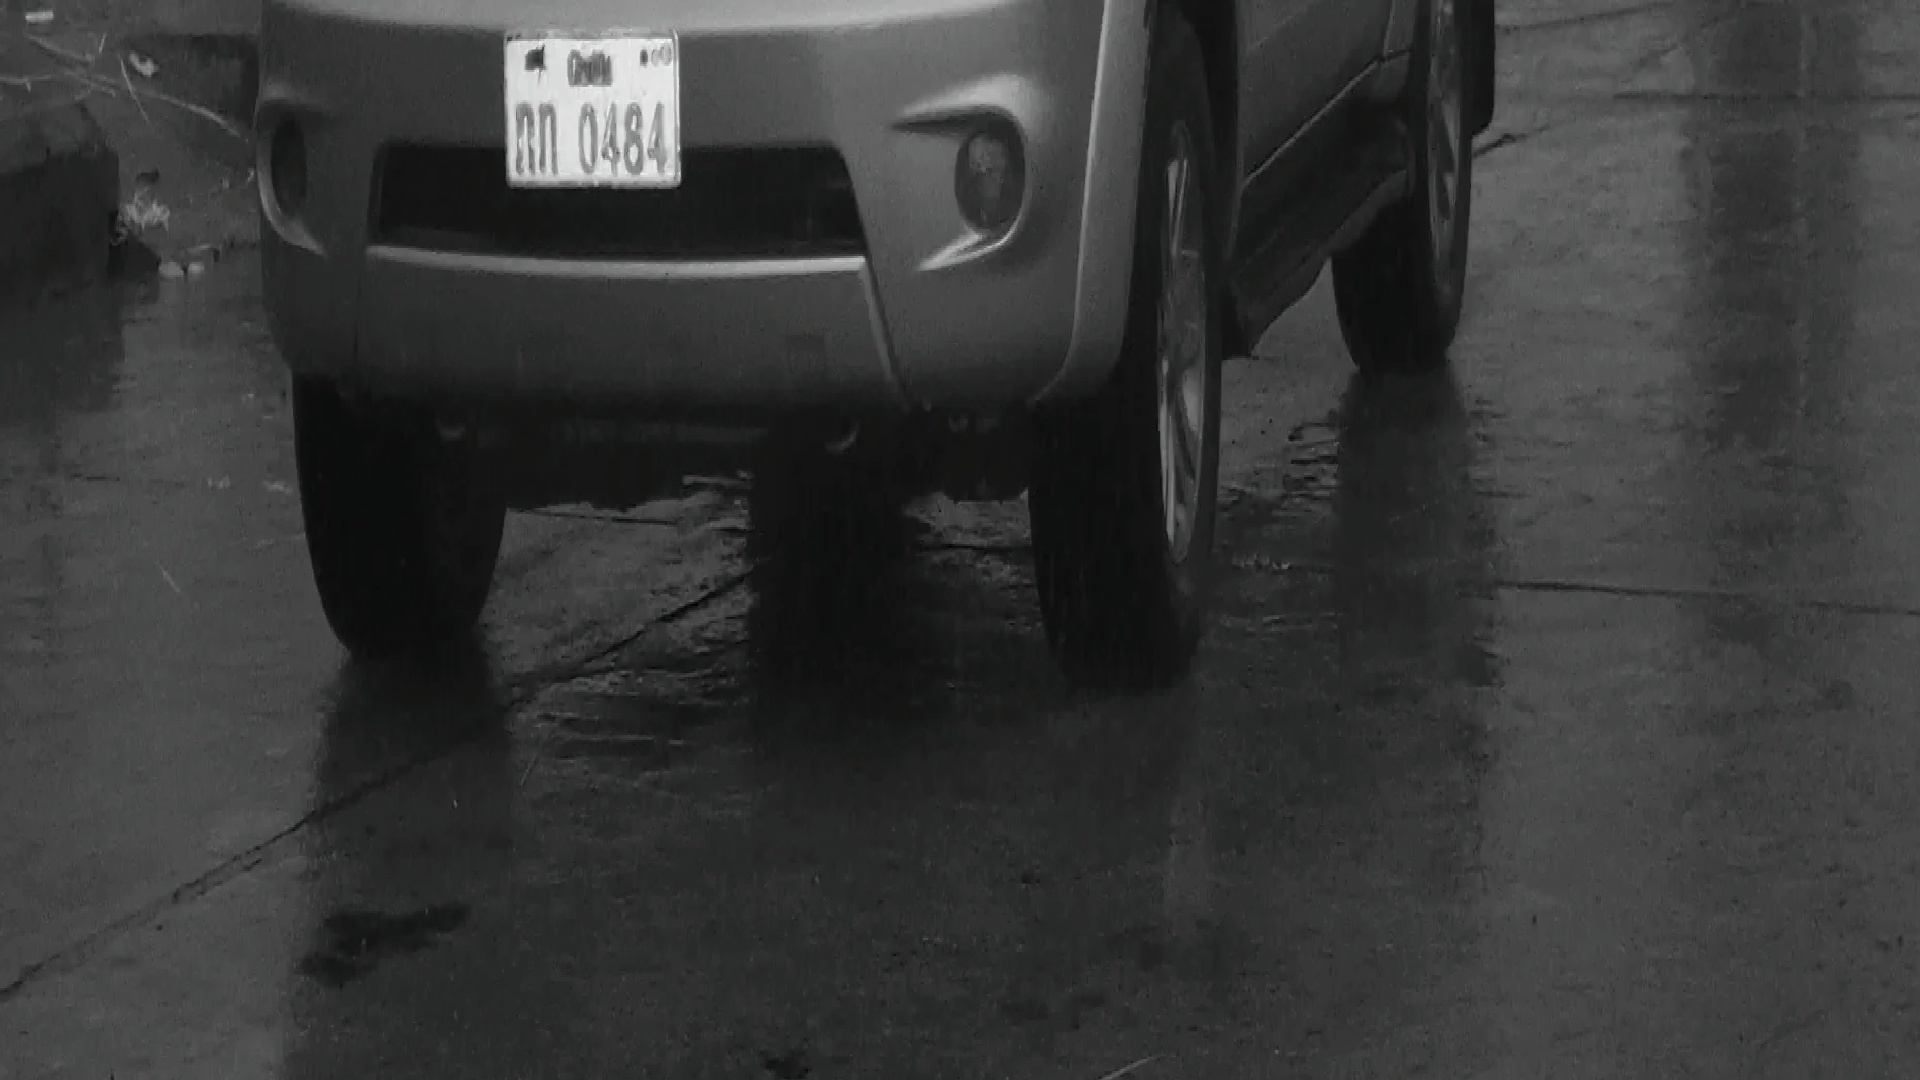

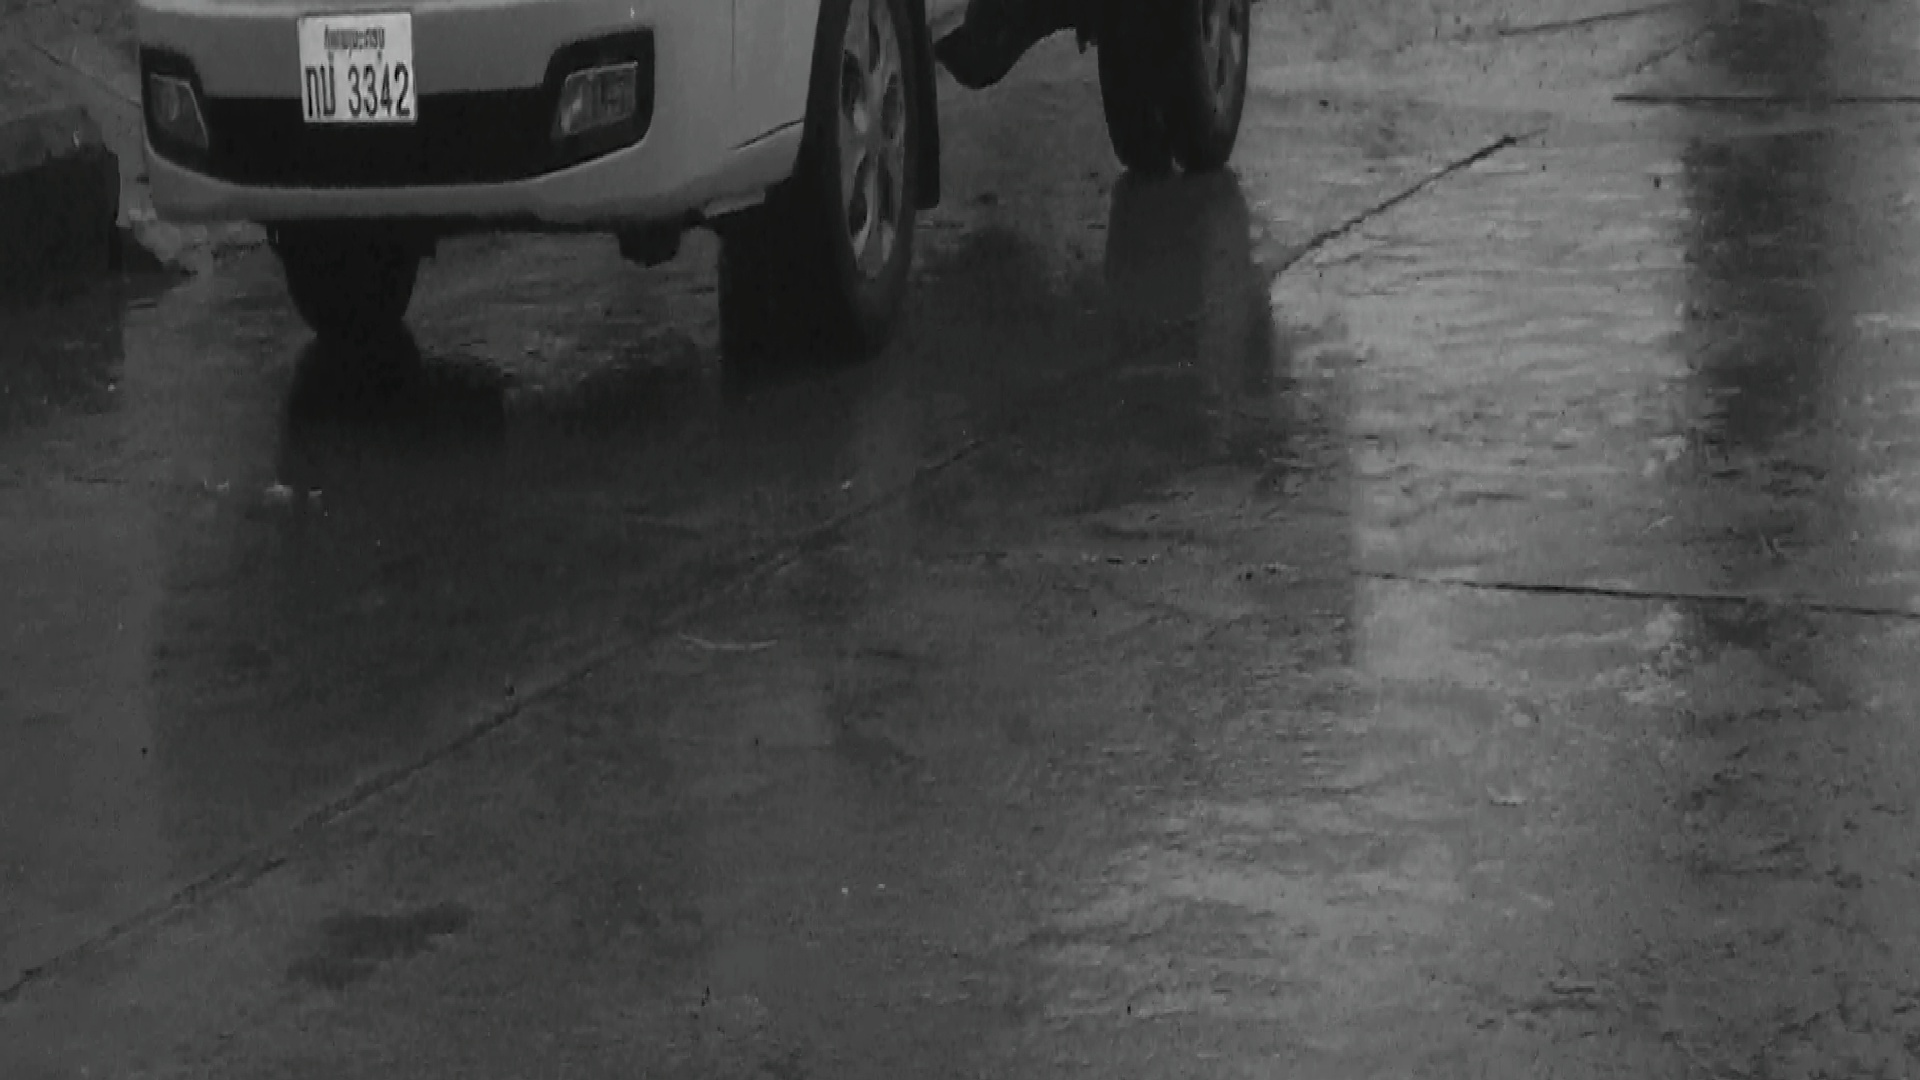

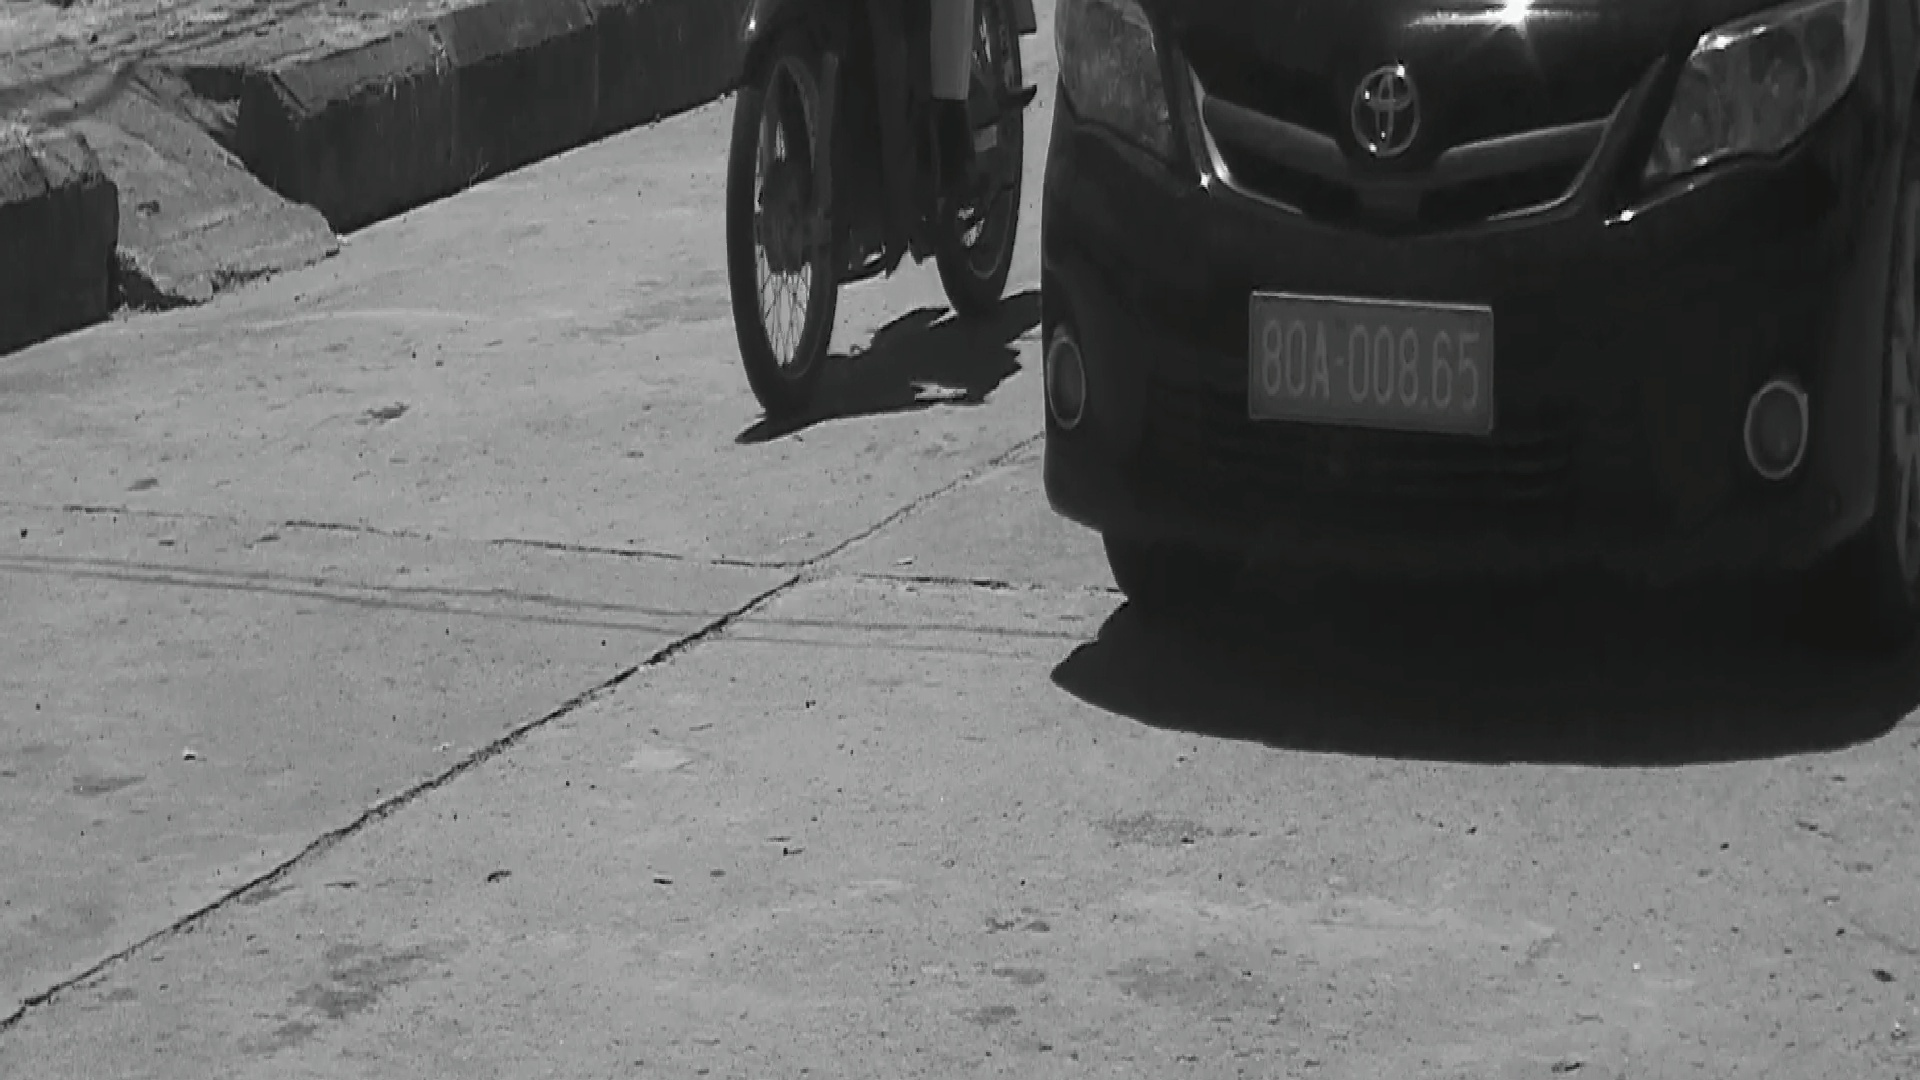

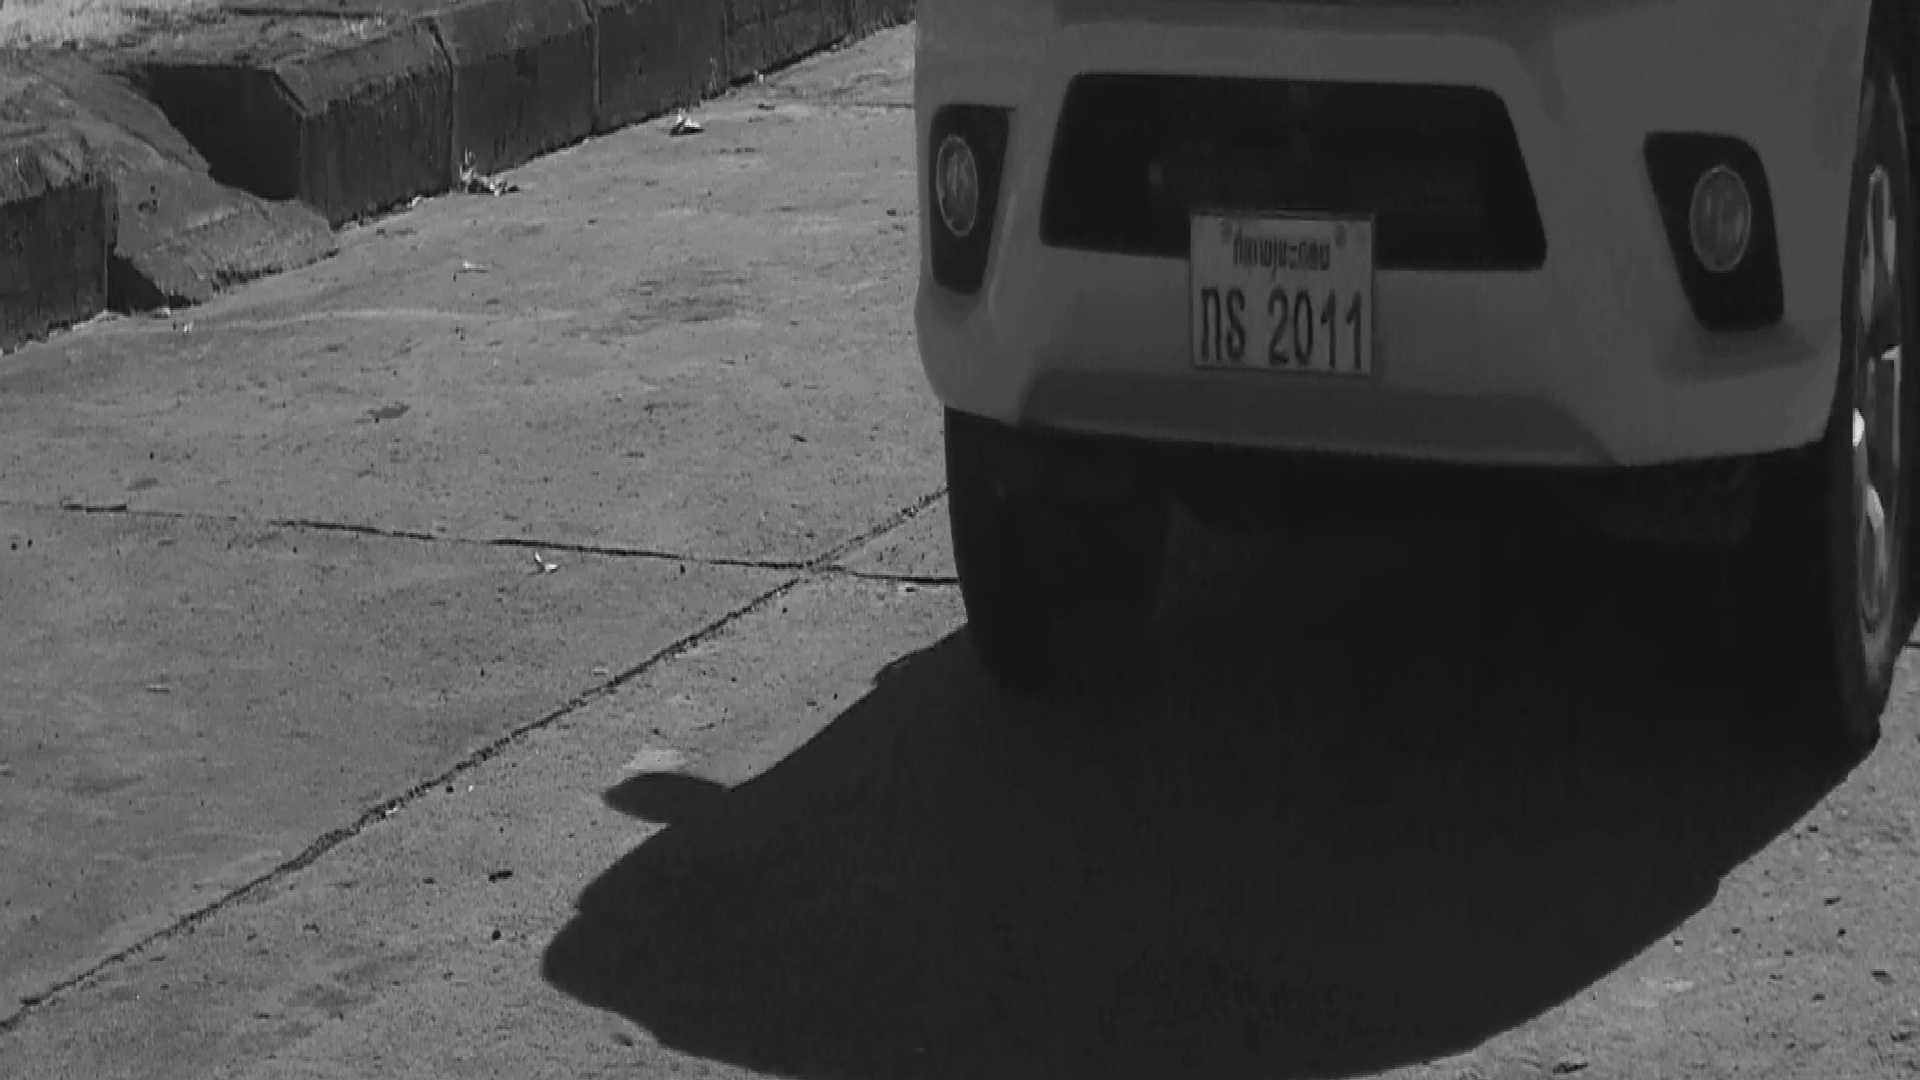

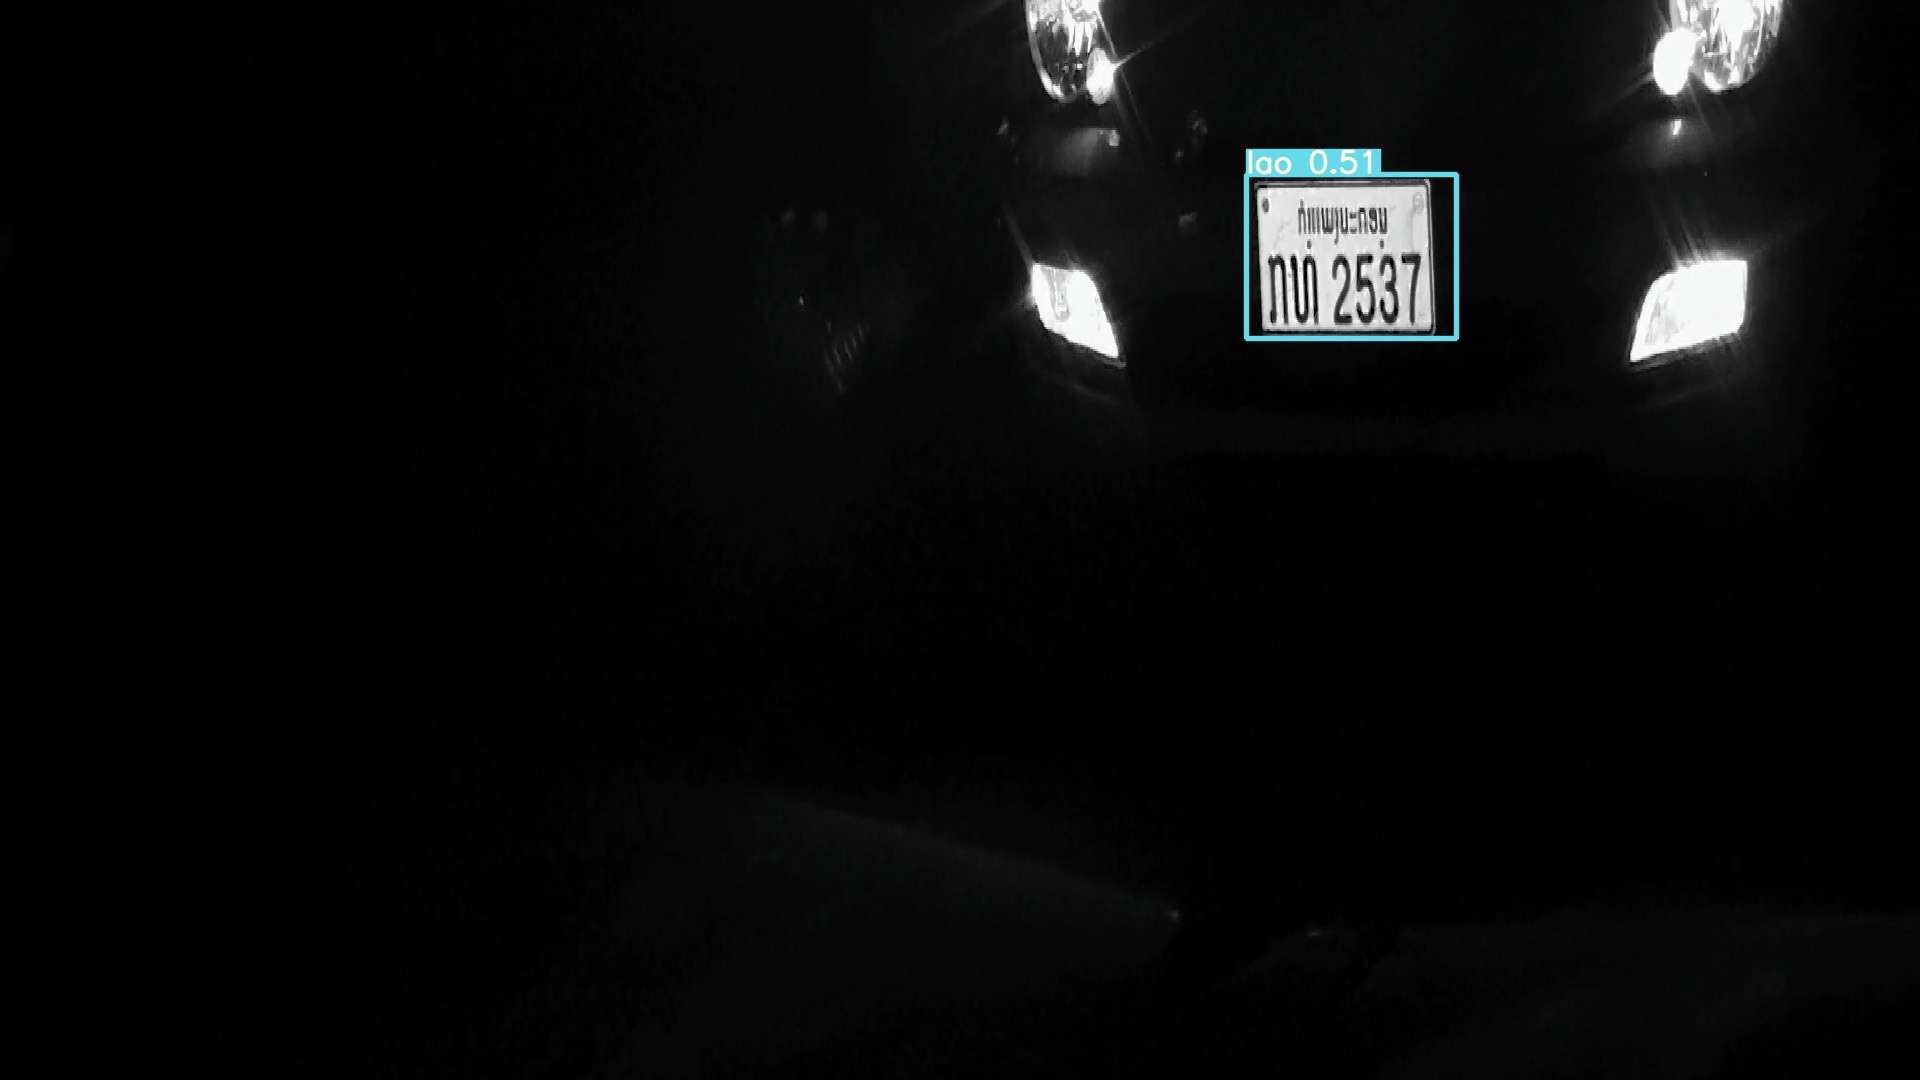

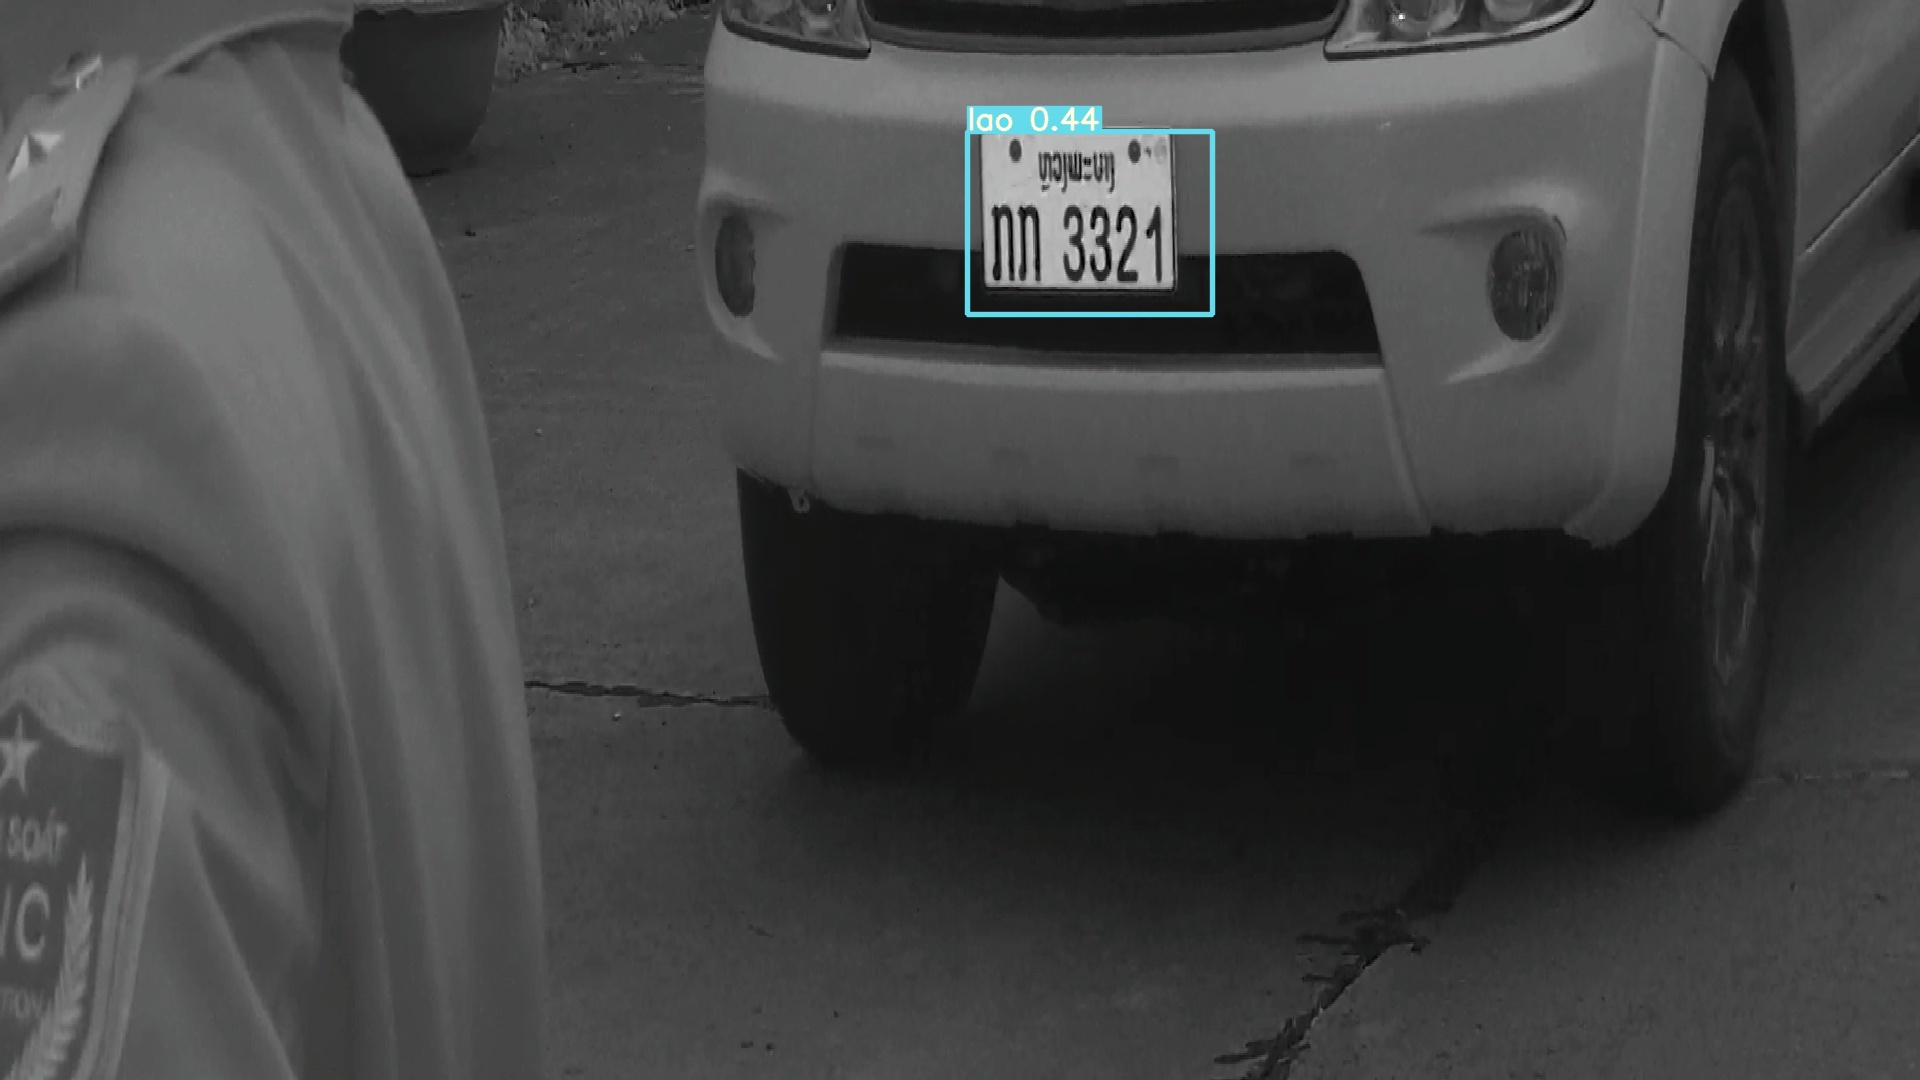

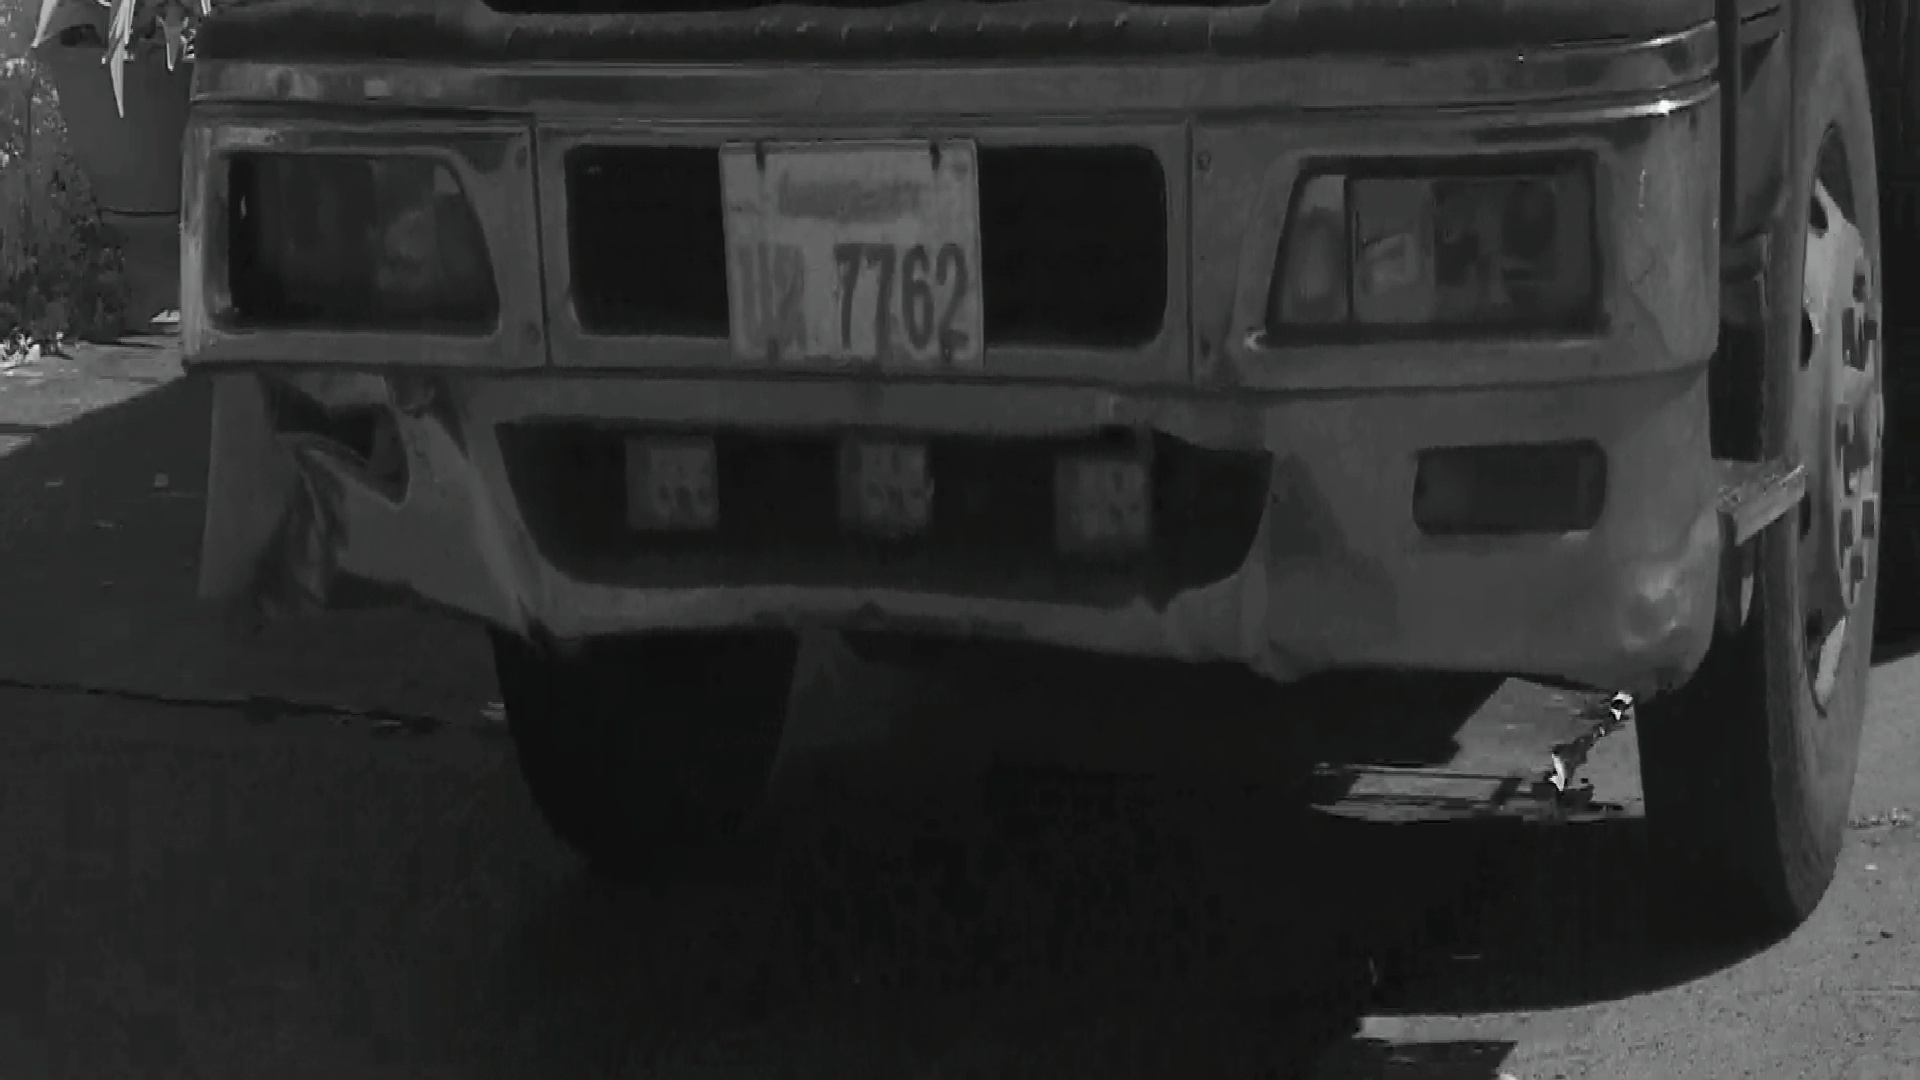

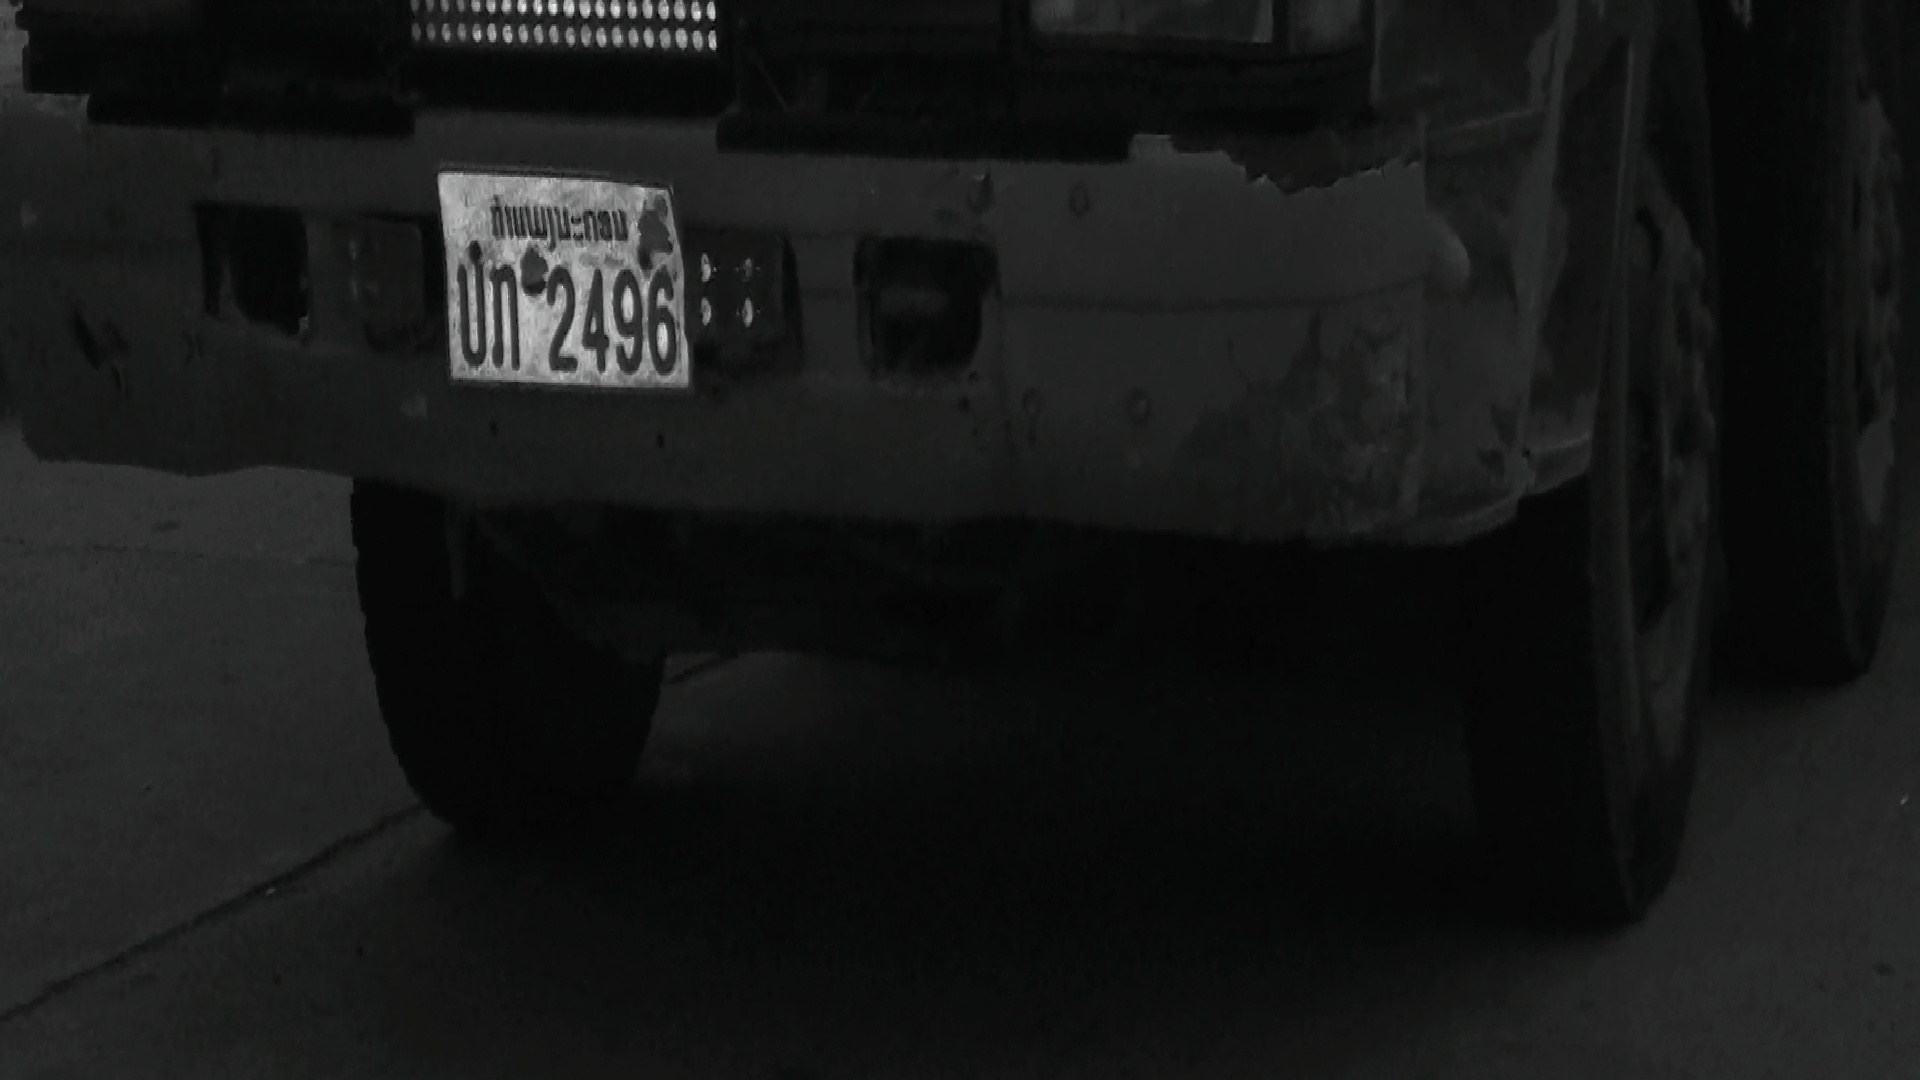

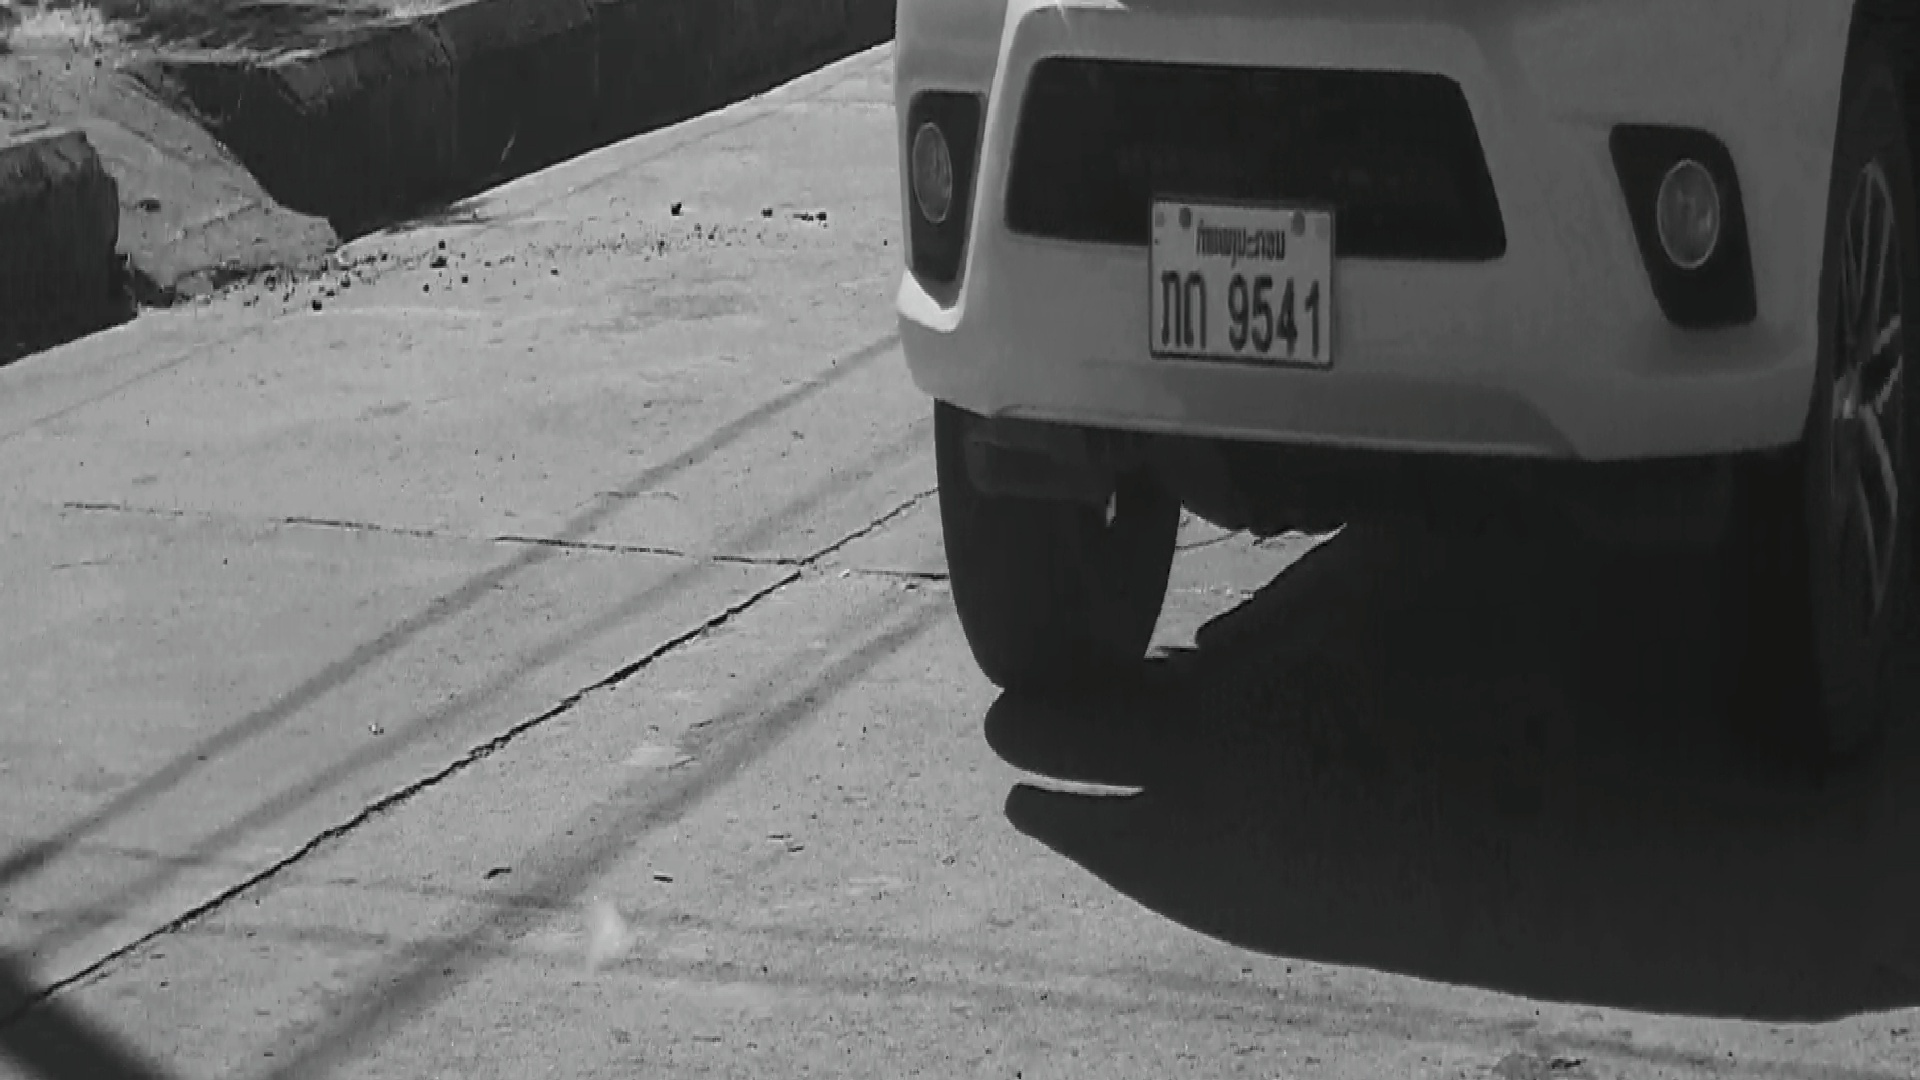

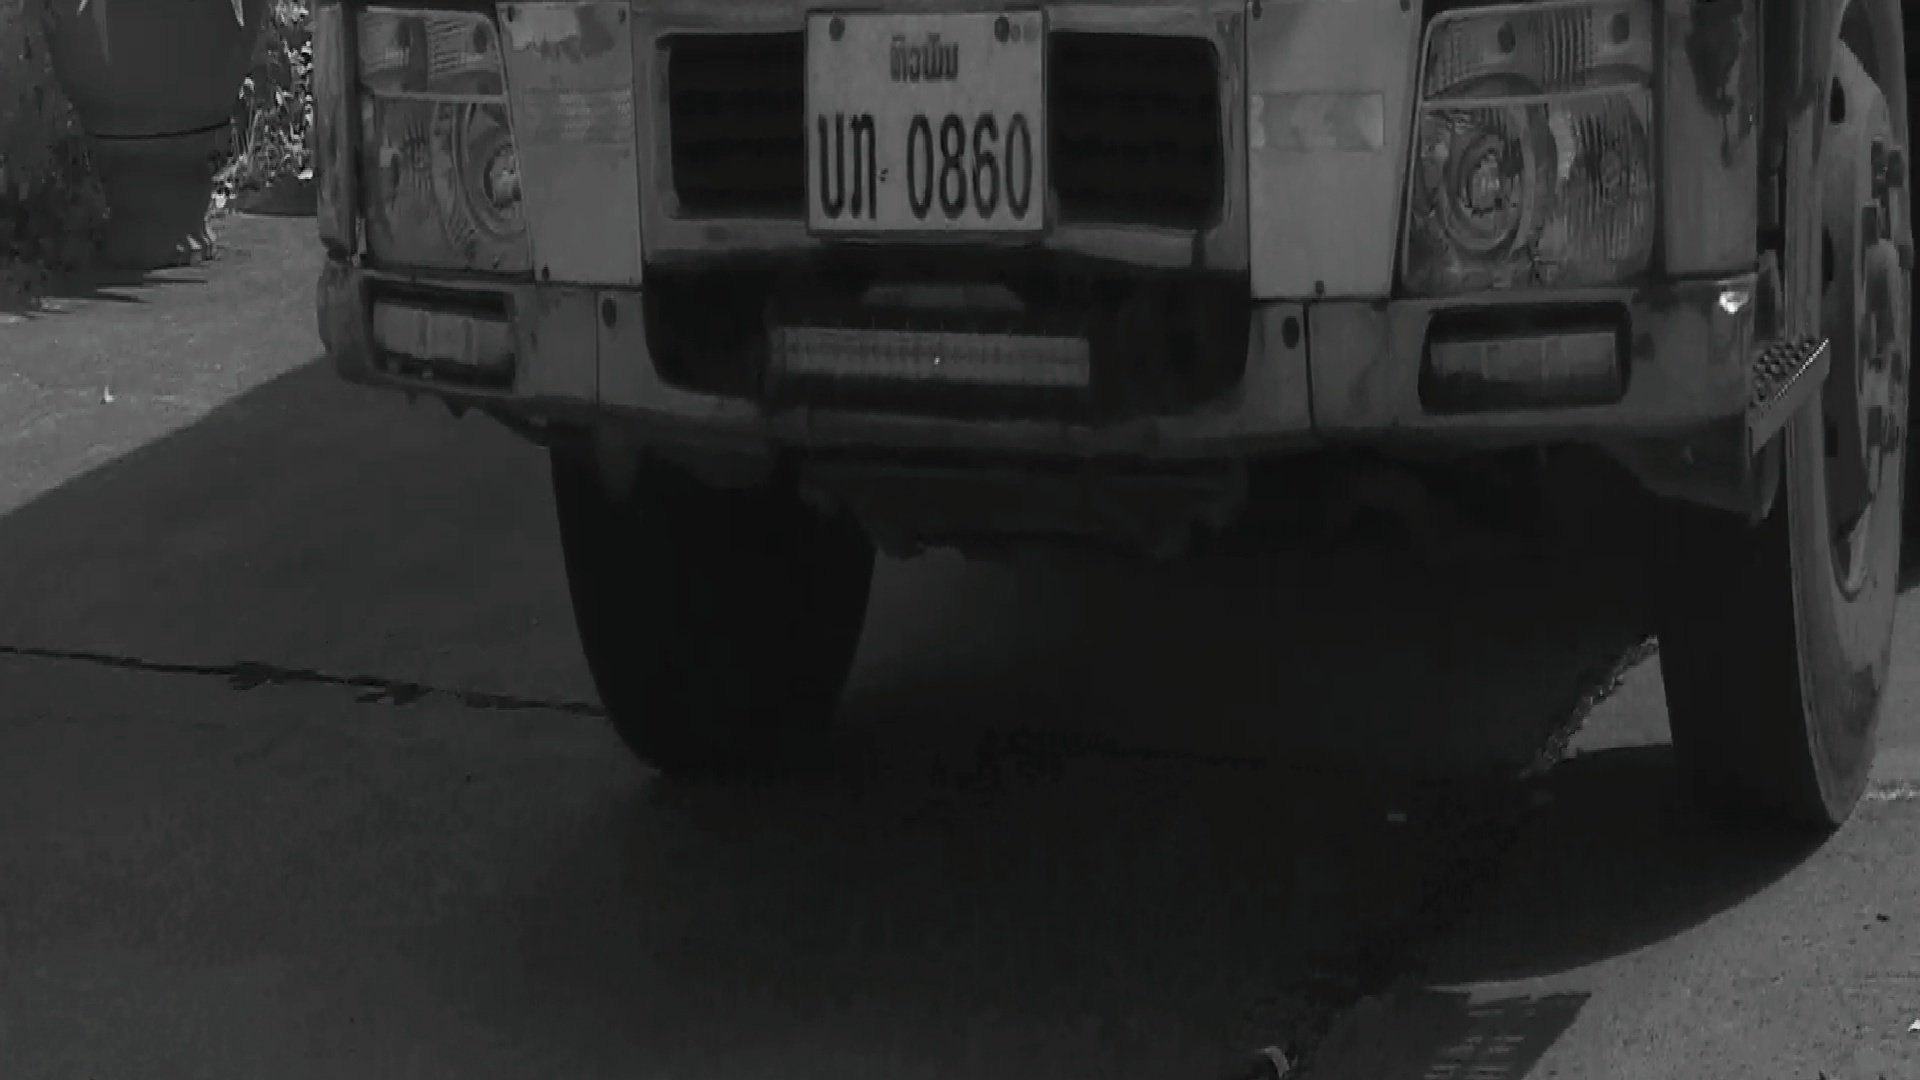

In [6]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('runs/detect/exp2_416/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere